In [1]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-01-18 10:53:01--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-01-18 10:53:01--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd245d867543694dad6a3853c06.dl-eu.dropboxusercontent.com/cd/0/inline/B0zss_7a09f0wIMbesCAhqxqnEjjNcFeovpTHDrMTCFJ5Rpbd1A2B9hCeE4XUAV7_LXZm79c7uxlTHRUHHK77uch5Q5mequz7z-4FUIPAfgG4HQMsdGaqvpX1XqqR7W7ECcfT_rdf6tPD0QfTFafKRAgWkfOxNLqrjsNzJ7W9aXhJw/file# [following]
--2023-01-18 10:53:02--  https://ucd245d867543694dad6a3853c06.dl-eu.dropboxusercontent.com/cd/0/inline/B0zss_7a09f0wIMbesCAhqxqnEjjNcFeovpTHDrMTCFJ5Rpbd1A2B9

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchvision import models,transforms

In [3]:
class MyDatasetcsv(Dataset):
  def __init__(self,path,trans = None) -> None:
     super().__init__() 
     self.data = pd.read_csv(path).to_numpy() 
     self.image =self.data[:,1:]
     self.labels =self.data[:,0]
     self.trans = trans

  def __len__(self):
    return self.data.shape[0] 
    
  def __getitem__ (self,index):
    im = self.image[index,:]
    label = self.labels[index]
    im = np.reshape(im,(28,28))/255
    if self.trans :
      im = self.trans(im)
    return (im, label)

In [4]:
!ls 

data.zip		 sample_data		 train-images-idx3-ubyte
fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-labels-idx1-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte


In [5]:
train_dataset = MyDatasetcsv("fashion-mnist_train.csv",
                        transforms.Compose([
                          transforms.ToTensor(),
                          # transforms.RandomCrop(28, padding=4),
                          # transforms.RandomAffine(30),
                          # transforms.ColorJitter(brightness=(0.1,0.6), contrast=1,saturation=0, hue=0.4),
                          # transforms.RandomPerspective()
                          
                    ])
)
test_dataset = MyDatasetcsv("fashion-mnist_test.csv")

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([64, 1, 28, 28])

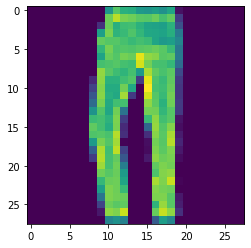

In [10]:
plt.imshow(batch[0][30][0])

## ..

## ...

In [462]:
class AutoEncoder(nn.Module):
    def __init__(self,nz):
        super(AutoEncoder, self).__init__()
        print(nz)
        # Encoder---------------
        #(1,28,28)
        self.econv1 = nn.Conv2d(1,16,3,2,1) 
        self.ebn1 = nn.BatchNorm2d(16)
        #(16,14,14)

        self.econv2 = nn.Conv2d(16,32,3,2,1) 
        self.ebn2 = nn.BatchNorm2d(32)
        #(32,7,7)

        self.econv3 = nn.Conv2d(32,64,3,2,1) 
        self.ebn3 = nn.BatchNorm2d(64)

        #(64,4,4)

        self.e1 = nn.Linear(4*4*64,64)
        self.e2 = nn.Linear(64,nz)
        
        # params layer---------------
        self.pr1 = nn.Linear(nz, nz)
        self.pr2 = nn.Linear(nz, nz)

        # Decoder---------------
        self.d1 = nn.Linear(nz, 64)
        self.dbn1 = nn.BatchNorm2d(64)

        self.d2 = nn.Linear(64,4*4*64)
        self.dbn1 = nn.BatchNorm2d(64*4*4)
        
        self.dconv1 = nn.ConvTranspose2d(64,32,3,2,1) 
        self.dbn3 = nn.BatchNorm2d(32)

        self.dconv2 = nn.ConvTranspose2d(32,16,3,2,1,output_padding=1)
        self.dbn4 = nn.BatchNorm2d(16)

        self.dconv3 = nn.ConvTranspose2d(16,1,3,2,1,output_padding=1)
        

'''---------------------------encoder------------------------------'''
    def encoder(self,x):
        # print('1ec',x.shape)
        x = torch.relu(self.econv1(x))
        x = self.ebn1(x) #torch.Size([64, 16, 14, 14])

        # print('2ec',x.shape)
        x = torch.relu(self.econv2(x))
        x = self.ebn2(x) #torch.Size([64, 32, 7, 7])

        # print('3ec',x.shape)
        x = torch.relu(self.econv3(x))
        x = self.ebn3(x) #torch.Size([64, 64, 4, 4])
        print(x.shape)
        x = x.view(-1,64*4*4)
        #x = x.view(-1,x.size(1)*x.size(2)*x.size(3))


        # x = x.view(4*4*64,-1)
        x = torch.relu(self.e1(x))
        x = torch.sigmoid(self.e2(x))
        return x


'''----------------------------getparams-----------------------------'''
    def get_params(self, x):
      mu = self.pr1(x)
      logvar = self.pr2(x)
      return (mu, logvar)
'''--------------------------repram-------------------------------'''

    def reparm(self, mu, logvar):
      eps = torch.randn(mu.shape).to(device)
      z = mu + eps* torch.exp(0.5*logvar)
      return z
'''---------------------------decoder------------------------------'''
    def decoder(self,x):
        x = torch.relu(self.d1(x))
       
        x = torch.relu(self.d2(x))
     
        # print(x.shape)
        x = x.view(-1,64 ,4 ,4 )
        x = torch.relu(self.dconv1(x)) #torch.Size([64, 32, 7, 7])
        x = self.dbn3(x) 
        
        x = torch.relu(self.dconv2(x)) #torch.Size([64, 16, 14, 14])
        x = self.dbn4(x) 
        
        x = torch.sigmoid(self.dconv3(x))
        return x

    def forward(self,x):
      x = self.encoder(x)
      mu, logvar = self.get_params(x)
      z = self.reparm(mu, logvar)
      x = self.decoder(z)
      return (z, mu, logvar, x)


    

In [464]:

x, y = next(iter(train_loader))
x = x.type(torch.FloatTensor).to(device)


In [482]:

def vae_loss(xhat, x, mu, logvar):
  KL_WEIGHT = 0.0012
  recon_loss = F.mse_loss(xhat, x)
  kl_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar) - mu*mu), axis =1), axis =0)
  return (1-KL_WEIGHT)*recon_loss + (KL_WEIGHT)*kl_loss

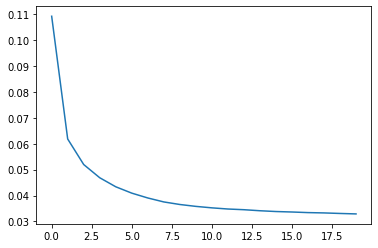

In [492]:
device = torch.device("cuda:0")

nz = 32
net = AutoEncoderConv(nz).to(device)
num_epochs = 20
lr = 1e-4
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].type(torch.FloatTensor).to(device)
    Z, mu, logvar, Xhat = net(X)
    loss = vae_loss(Xhat, X, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  ls.append(total_loss/len(train_loader))
plt.plot(ls)

In [493]:
x.shape

torch.Size([64, 1, 28, 28])

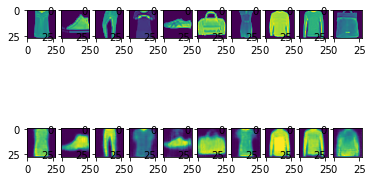

In [494]:
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy())

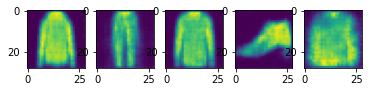

In [511]:
with torch.no_grad():
  net.eval()
  z= torch.randn(10,nz).to(device)

  xgen = net.decoder(z)

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(xgen.cpu().numpy()[i,0,:,:])